In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [7]:
BATCH_SIZE =32
IMAGE_SIZE=256
CHANNEL = 3

In [8]:
dataset = tf.keras.utils.image_dataset_from_directory(
"PlantVillage",
    seed=212,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 20638 files belonging to 15 classes.


In [9]:
class_names=dataset.class_names
n_class=len(dataset.class_names)
print(n_class)

15


In [10]:
print(len(dataset))

645


In [11]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[ 5  0  6  5  5  5 12 12  5  3 14  5  3  5  3  5 14  3 11 11  0  7  3 10
 12 11  8 11 12  8  2  8]


#  **Visualize data**

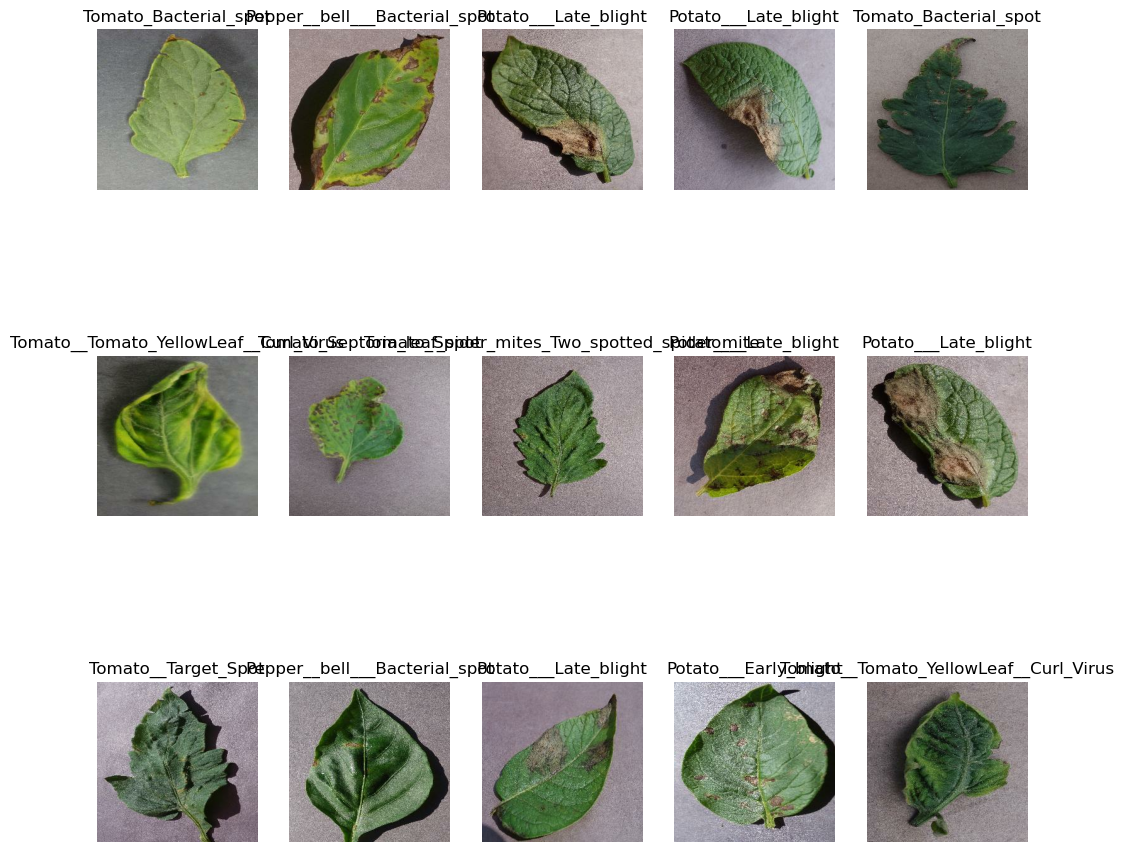

In [12]:
plt.figure(figsize=(12,12))
for image_batch , label_batch in dataset.take(1):
    for i in range(15) : 
        ax = plt.subplot(3,5,i+1)
        #convert the array from tensor to numpy array
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    

In [13]:
def get_train_val_test_split(ds,shuffle=True,shuffle_size=100):
    ds_size=len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size=int(ds_size*0.8)
    val_size=int(ds_size*0.1)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [14]:
train_ds,val_ds,test_ds=get_train_val_test_split(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

516
64
65


# Data preprocessing 

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.3)
])

# BUILD CNN MODEL

In [17]:
input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNEL)
classifier = Sequential()
#resize and augmentation
classifier.add(resize_and_rescale)
classifier.add(data_augmentation)
# Convolution Step 1
classifier.add(Conv2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=input_shape, activation = 'relu'))
classifier.add(BatchNormalization())
# Max Pooling Step 1
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())

# Convolution Step 2
classifier.add(Conv2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Max Pooling Step 2
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
classifier.add(BatchNormalization())

# Convolution Step 3
classifier.add(Conv2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 4
classifier.add(Conv2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 5
classifier.add(Conv2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))

# Max Pooling Step 3
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())
# Flattening Step
classifier.add(Flatten())
# Full Connection Step
classifier.add(Dense(units = 4096, activation = 'relu'))
classifier.add(Dropout(0.3))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 2048, activation = 'relu'))
classifier.add(Dropout(0.3))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 1024, activation = 'relu'))
classifier.add(Dropout(0.6))
classifier.add(BatchNormalization())
classifier.add(Dense(units = n_class, activation = 'softmax'))



In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
early_stopping=EarlyStopping(monitor='val_accuracy', min_delta=0.00005, patience=6, verbose=1, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1,
)
callbacks = [
    early_stopping,
    lr_scheduler    
]
classifier.compile(optimizer=opt,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])


In [20]:
history = classifier.fit(train_ds ,validation_data = val_ds , batch_size = 32 , epochs = 20,shuffle=True,callbacks = callbacks)


Epoch 1/20
516/516 [==============================] - 600s 1s/step - loss: 2.5803 - accuracy: 0.2716 - val_loss: 2.4976 - val_accuracy: 0.2456 - lr: 1.0000e-05
Epoch 2/20
516/516 [==============================] - 601s 1s/step - loss: 2.0087 - accuracy: 0.4138 - val_loss: 1.7731 - val_accuracy: 0.4927 - lr: 1.0000e-05
Epoch 3/20
516/516 [==============================] - 594s 1s/step - loss: 1.7424 - accuracy: 0.4823 - val_loss: 1.4868 - val_accuracy: 0.5621 - lr: 1.0000e-05
Epoch 4/20
516/516 [==============================] - 590s 1s/step - loss: 1.5551 - accuracy: 0.5299 - val_loss: 1.5734 - val_accuracy: 0.5591 - lr: 1.0000e-05
Epoch 5/20
516/516 [==============================] - 593s 1s/step - loss: 1.4090 - accuracy: 0.5710 - val_loss: 1.7803 - val_accuracy: 0.5835 - lr: 1.0000e-05
Epoch 6/20
516/516 [==============================] - 591s 1s/step - loss: 1.2802 - accuracy: 0.6014 - val_loss: 2.1073 - val_accuracy: 0.5396 - lr: 1.0000e-05
Epoch 7/20
516/516 [====================

In [21]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 96)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 31, 31, 96)      

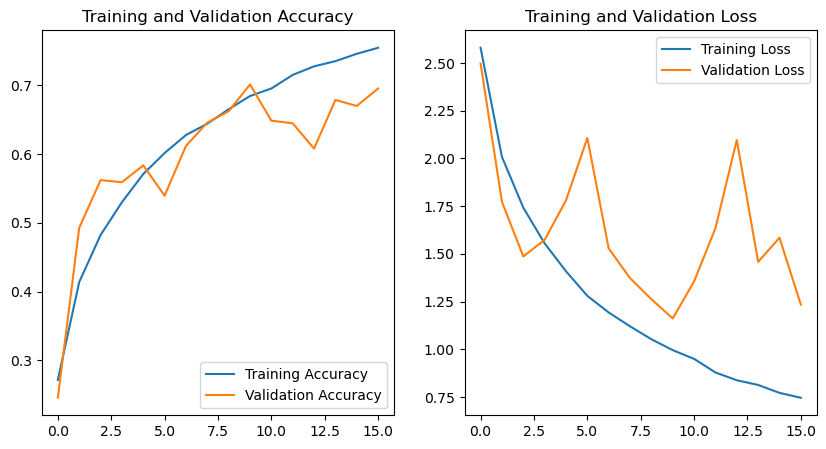

In [22]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']



plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 160ms/step


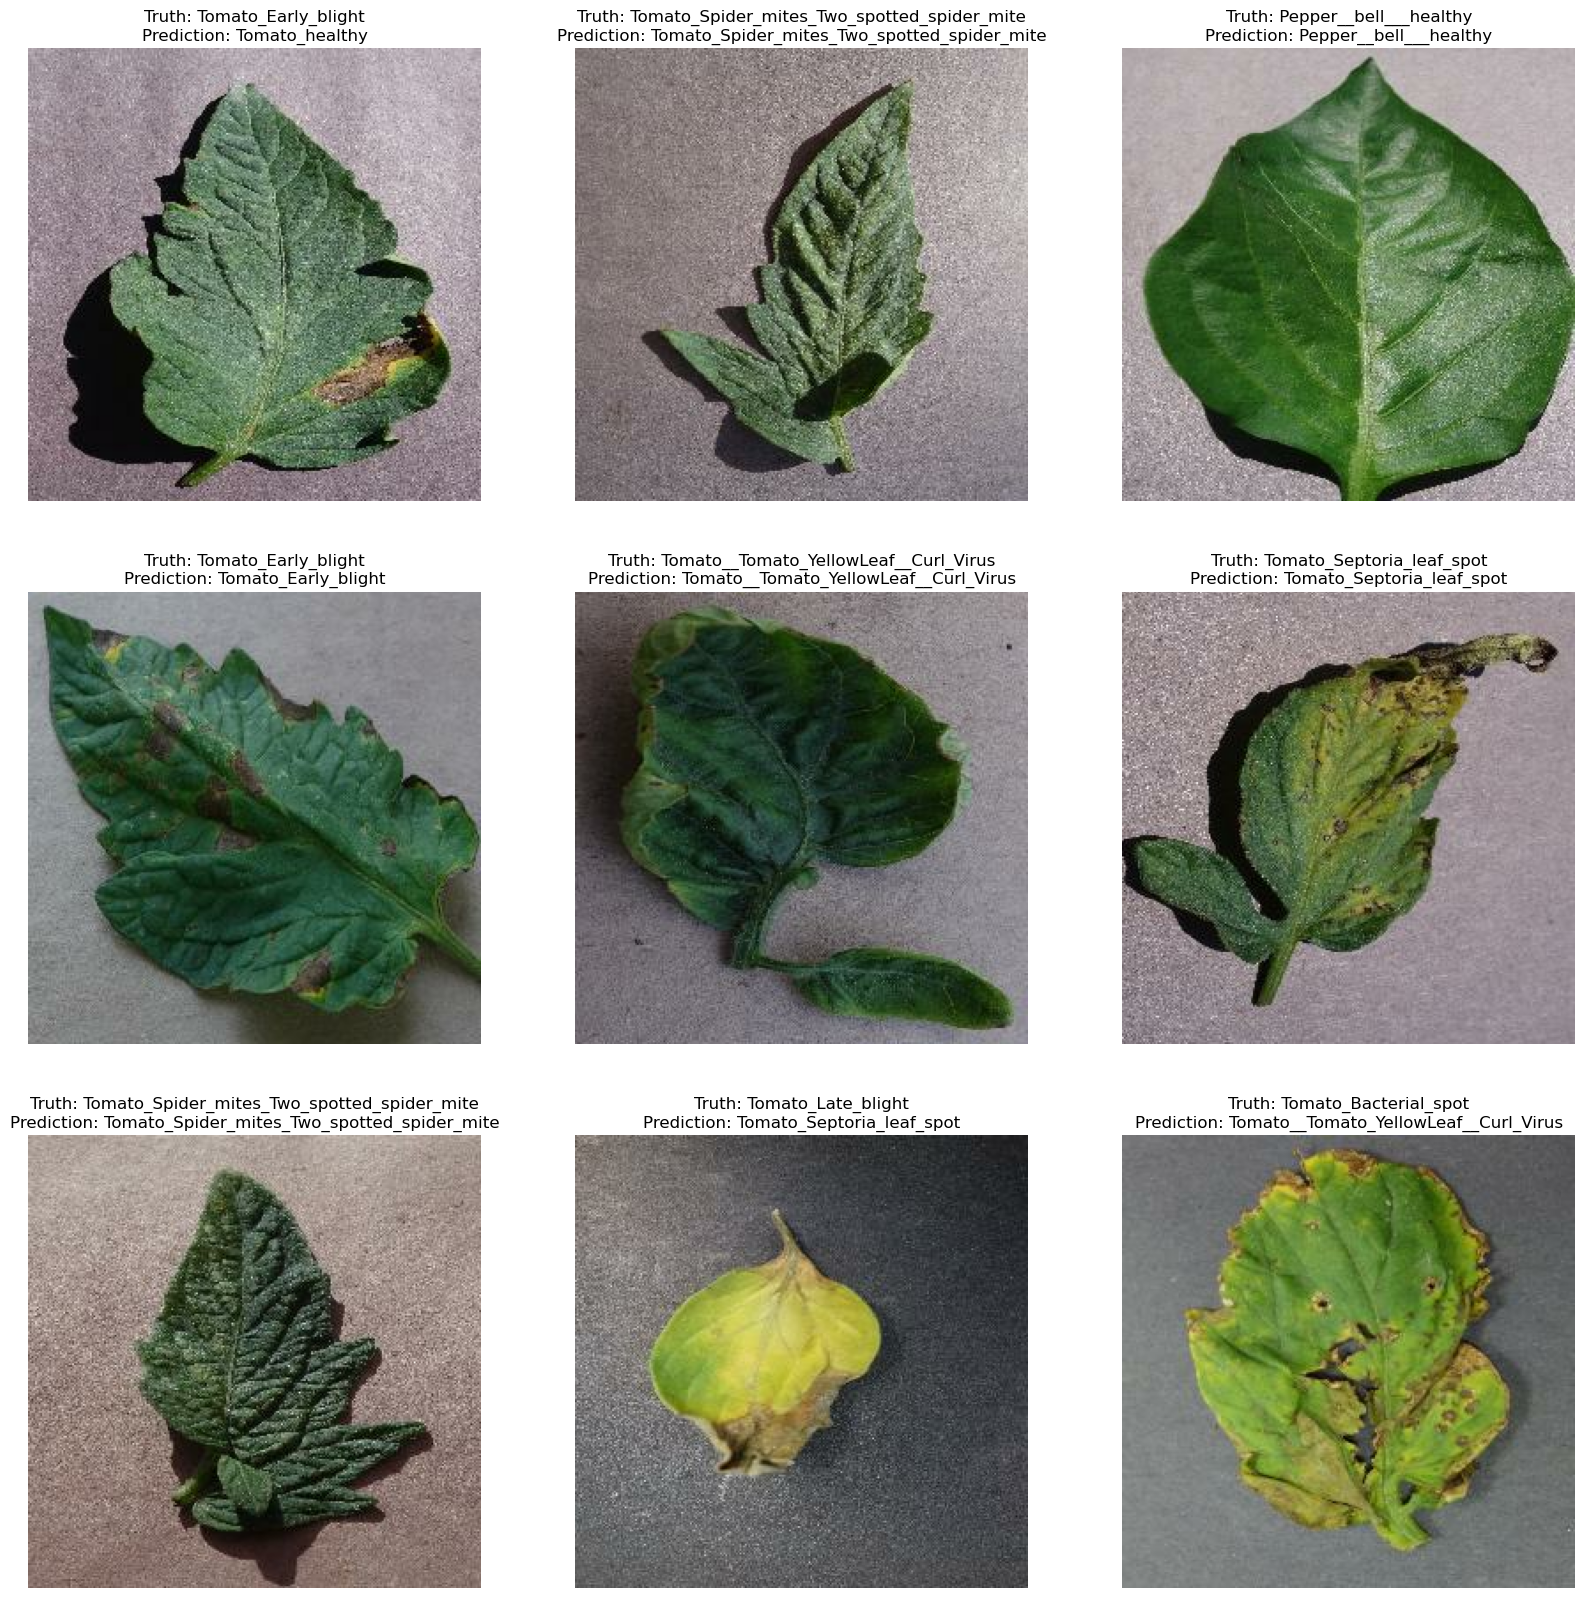

In [23]:
plt.figure(figsize=(20,20))
for img, label in test_ds.take(1):
    for i in range(9):
        prediction = classifier.predict(img)
        ax = plt.subplot(3, 3, i+1)
        score = tf.nn.softmax(prediction[i])
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title('Truth: ' + class_names[label[i]] +
                  "\n" + 'Prediction: ' + class_names[np.argmax(score)])
        plt.axis('off'),
        plt.tight_layout

In [24]:
classifier.save("model.h5")